### Final Transit Imputation Summary and QA

This section summarizes missingness reductions for transit parameters, reports the number of values imputed per field, and verifies key physical constraints (positive durations, valid depth range).

In [147]:
import pandas as pd

In [148]:
# Import required libraries for exoplanet-specific imputation
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [149]:
df = pd.read_csv('data/unified_exoplanets.csv')
ORIG_DF_SHAPE = df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21224 entries, 0 to 21223
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   planet_name             21224 non-null  object 
 1   host_star_id            21224 non-null  object 
 2   mission                 21224 non-null  object 
 3   disposition             21224 non-null  object 
 4   orbital_period_days     21074 non-null  float64
 5   transit_epoch_bjd       17232 non-null  float64
 6   transit_duration_hours  17232 non-null  float64
 7   transit_depth_ppm       16869 non-null  float64
 8   planet_radius_re        19528 non-null  float64
 9   planet_mass_me          0 non-null      float64
 10  equilibrium_temp_k      17401 non-null  float64
 11  insolation_flux         17354 non-null  float64
 12  eccentricity            429 non-null    float64
 13  inclination_deg         0 non-null      float64
 14  impact_parameter        9201 non-null 

# Data Preprocessing

## Duplicate handling

In [150]:
df.shape

(21224, 23)

In [151]:
df[df.duplicated()]

,planet_name,host_star_id,mission,disposition,orbital_period_days,transit_epoch_bjd,transit_duration_hours,transit_depth_ppm,planet_radius_re,planet_mass_me,...,inclination_deg,impact_parameter,stellar_teff_k,stellar_radius_rsun,stellar_mass_msun,stellar_metallicity,stellar_logg,ra,dec,tic_id
11465,HD 3167 c,HD 3167,K2,CONFIRMED,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.740149,4.380721,NaN
12863,K2-370 b,K2-370,K2,CONFIRMED,2.140840,NaN,NaN,NaN,3.20700,NaN,...,NaN,NaN,5377.0,0.971,0.984,0.018,4.454,67.820530,19.831690,NaN
12877,K2-374 b,K2-374,K2,CONFIRMED,4.521953,NaN,NaN,NaN,1.59300,NaN,...,NaN,NaN,5789.0,0.907,0.731,-0.292,4.386,137.379499,16.355832,NaN
12879,K2-374 c,K2-374,K2,CONFIRMED,16.434450,NaN,NaN,NaN,2.21300,NaN,...,NaN,NaN,5789.0,0.907,0.731,-0.292,4.386,137.379499,16.355832,NaN
12885,K2-376 b,K2-376,K2,CONFIRMED,5.776475,NaN,NaN,NaN,1.73600,NaN,...,NaN,NaN,5937.0,1.149,0.908,-0.176,4.275,132.719333,25.038082,NaN
12946,K2-388 b,K2-388,K2,CONFIRMED,6.339069,NaN,NaN,NaN,3.66000,NaN,...,NaN,NaN,5367.0,0.897,0.842,0.124,4.456,352.713934,-11.077356,NaN
12952,K2-389 c,K2-389,K2,CONFIRMED,20.851337,NaN,NaN,NaN,2.04000,NaN,...,NaN,NaN,5782.0,1.084,0.802,-0.034,4.273,355.630415,-9.713581,NaN
12961,K2-390 b,K2-390,K2,CONFIRMED,3.312792,NaN,NaN,NaN,4.66200,NaN,...,NaN,NaN,5558.0,0.966,0.789,-0.116,4.368,355.702386,-9.588712,NaN
12964,K2-391 b,K2-391,K2,CONFIRMED,4.622654,NaN,NaN,NaN,1.37100,NaN,...,NaN,NaN,5543.0,0.566,0.757,-0.543,4.973,356.226015,-7.701515,NaN
12966,K2-392 b,K2-392,K2,CONFIRMED,15.398723,NaN,NaN,NaN,1.85000,NaN,...,NaN,NaN,5726.0,1.058,0.841,-0.238,4.314,354.649906,-7.478882,NaN


In [152]:
df.drop_duplicates(inplace=True)    
df.shape

(21196, 23)

## Null Value Analysis

In [153]:
df.isna().mean() * 100

planet_name                 0.000000
host_star_id                0.000000
mission                     0.000000
disposition                 0.000000
orbital_period_days         0.702963
transit_epoch_bjd          18.701642
transit_duration_hours     18.701642
transit_depth_ppm          20.414229
planet_radius_re            7.996792
planet_mass_me            100.000000
equilibrium_temp_k         17.904322
insolation_flux            18.126062
eccentricity               97.976033
inclination_deg           100.000000
impact_parameter           56.590866
stellar_teff_k              7.709002
stellar_radius_rsun         4.694282
stellar_mass_msun          90.210417
stellar_metallicity        92.116437
stellar_logg               13.516701
ra                          0.000000
dec                         0.000000
tic_id                     63.823363
dtype: float64

### Setting Threshold
This is to drop the columns with nulls > 90%

In [154]:
null_pct = df.isna().mean() * 100
cols_to_drop = null_pct[null_pct > 90].index.tolist()

if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"Dropped {len(cols_to_drop)} columns: {cols_to_drop}")

row_null_pct = df.isna().mean(axis=1) * 100
rows_to_drop = df.index[row_null_pct > 40].tolist()

if rows_to_drop:
    df.drop(index=rows_to_drop, inplace=True)
    print(f"Dropped {len(rows_to_drop)} rows with >40% nulls")

print("Remaining columns:", df.columns.tolist())
print("New shape:", df.shape)

Dropped 5 columns: ['planet_mass_me', 'eccentricity', 'inclination_deg', 'stellar_mass_msun', 'stellar_metallicity']
Dropped 2480 rows with >40% nulls
Remaining columns: ['planet_name', 'host_star_id', 'mission', 'disposition', 'orbital_period_days', 'transit_epoch_bjd', 'transit_duration_hours', 'transit_depth_ppm', 'planet_radius_re', 'equilibrium_temp_k', 'insolation_flux', 'impact_parameter', 'stellar_teff_k', 'stellar_radius_rsun', 'stellar_logg', 'ra', 'dec', 'tic_id']
New shape: (18716, 18)


In [155]:
df.isna().mean() * 100

planet_name                0.000000
host_star_id               0.000000
mission                    0.000000
disposition                0.000000
orbital_period_days        0.582389
transit_epoch_bjd          9.868562
transit_duration_hours     9.868562
transit_depth_ppm          9.868562
planet_radius_re           2.783714
equilibrium_temp_k         7.095533
insolation_flux            7.512289
impact_parameter          50.838854
stellar_teff_k             0.892285
stellar_radius_rsun        2.703569
stellar_logg               5.391109
ra                         0.000000
dec                        0.000000
tic_id                    59.029707
dtype: float64

### Transit Parameters (Moderate Missingness 10-30%)
For `transit_epoch_bjd`, `transit_duration_hours`, `transit_depth_ppm`

The earlier note comparing our imputation to Luz et al. (2024) has been revised for precision. Luz et al. evaluate classifiers for exoplanet candidate validation and employ simple strategies like mean imputation primarily for experimentation consistency; they do not propose or validate a domain-tailored imputation framework for transit parameters. Our approach—kNN/MICE for transits, regression for stellar/planetary radii, and distribution-aware bounded imputation for impact parameter—serves a different purpose: constructing a scientifically usable, maximally complete dataset with explicit uncertainty estimates. Where relevant, we align with the spirit of minimizing bias and propagating uncertainty, but we do not claim direct superiority over their modeling choices, as the objectives and evaluation criteria differ.

#### Exoplanet Transit Parameter Imputation Setup
Import libraries and define the target transit parameters for imputation

In [156]:
# Define transit parameters to impute
TRANSIT_PARAMS = ['transit_epoch_bjd', 'transit_duration_hours', 'transit_depth_ppm']

# Features for similarity in exoplanet context
EXOPLANET_FEATURES = [
    'orbital_period_days', 'period_days', 'pl_orbper',
    'planet_radius_re', 'planet_radius_earth', 'pl_rade',
    'equilibrium_temp_k', 'stellar_teff_k',
    'impact_parameter', 'stellar_radius_rsun'
]

print(f"Transit parameters to impute: {TRANSIT_PARAMS}")
print(f"Available features for similarity: {[f for f in EXOPLANET_FEATURES if f in df.columns]}")

Transit parameters to impute: ['transit_epoch_bjd', 'transit_duration_hours', 'transit_depth_ppm']
Available features for similarity: ['orbital_period_days', 'planet_radius_re', 'equilibrium_temp_k', 'stellar_teff_k', 'impact_parameter', 'stellar_radius_rsun']


#### Physical Constraints for Exoplanet Parameters
Apply domain-specific constraints to ensure physically reasonable values

In [157]:
def apply_exoplanet_constraints(data, period_col=None):
    """Apply physical constraints specific to exoplanet transit parameters"""
    data_clean = data.copy()
    
    # Transit duration constraints
    if 'transit_duration_hours' in data_clean.columns:
        # Must be positive
        data_clean.loc[data_clean['transit_duration_hours'] <= 0, 'transit_duration_hours'] = np.nan
        
        # Should be reasonable fraction of orbital period
        if period_col and period_col in data_clean.columns:
            period_hours = data_clean[period_col] * 24
            max_duration = period_hours * 0.15  # Max 15% of orbital period
            data_clean.loc[data_clean['transit_duration_hours'] > max_duration, 'transit_duration_hours'] = np.nan
    
    # Transit depth constraints (in ppm)
    if 'transit_depth_ppm' in data_clean.columns:
        # Must be positive and less than 100% (1e6 ppm)
        data_clean.loc[(data_clean['transit_depth_ppm'] <= 0) | 
                       (data_clean['transit_depth_ppm'] > 500000), 'transit_depth_ppm'] = np.nan
    
    return data_clean

# Find best period column available
period_col = None
for col in ['orbital_period_days', 'period_days', 'pl_orbper']:
    if col in df.columns and not df[col].isna().all():
        period_col = col
        break

print(f"Using period column: {period_col}")
print(f"Pre-constraint transit param stats:")
for param in TRANSIT_PARAMS:
    if param in df.columns:
        valid_count = df[param].notna().sum()
        print(f"  {param}: {valid_count} valid values")

Using period column: orbital_period_days
Pre-constraint transit param stats:
  transit_epoch_bjd: 16869 valid values
  transit_duration_hours: 16869 valid values
  transit_depth_ppm: 16869 valid values


#### Simplified k-Nearest Neighbors Imputation
Use k-NN with median imputation to avoid covariance matrix issues

In [158]:
def knn_impute_exoplanets(data, target_cols, feature_cols, k=20):
    """
    Simplified k-NN imputation for exoplanet data using median of neighbors
    Avoids covariance matrix issues by using simple median imputation from neighbors
    - Uses position indices robustly to avoid label/position mismatch, even with non-unique/non-monotonic index
    - Guards against empty feature set and very small datasets
    """
    data_imputed = data.copy()

    # Guard: need at least 1 feature and 2 rows
    if len(feature_cols) < 1 or len(data) < 2:
        print("k-NN imputation skipped: insufficient features or rows")
        imputed_flags = {col: np.zeros(len(data), dtype=bool) for col in target_cols}
        return data_imputed, imputed_flags

    # Prepare feature matrix for distance calculation
    feature_data = data[feature_cols].copy()

    # Fill features with median for distance calculation only
    feature_filled = feature_data.fillna(feature_data.median())

    # Standardize features
    scaler = StandardScaler()
    feature_scaled = scaler.fit_transform(feature_filled)

    # Set up k-NN (ensure neighbors < n_samples)
    n_neighbors = max(1, min(k, len(data) - 1))
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(feature_scaled)

    # Track imputation flags
    imputed_flags = {col: np.zeros(len(data), dtype=bool) for col in target_cols}

    # Impute each missing row (any of targets missing)
    missing_mask = data[target_cols].isna().any(axis=1)
    missing_positions = np.flatnonzero(missing_mask.to_numpy())

    print(f"Imputing {len(missing_positions)} rows with missing transit parameters...")

    # Pre-compute column positions for speed
    col_pos = {c: data.columns.get_loc(c) for c in target_cols if c in data.columns}

    for idx, pos in enumerate(missing_positions):
        if idx % 500 == 0:
            print(f"  Progress: {idx}/{len(missing_positions)}")

        # Find neighbors for this position
        _, neighbor_indices = knn.kneighbors([feature_scaled[pos]])
        neighbor_indices = neighbor_indices[0]

        # Remove self if present
        neighbor_indices = neighbor_indices[neighbor_indices != pos]

        # Get neighbor data by positional index
        neighbors = data.iloc[neighbor_indices]

        # Impute each missing target
        for col in target_cols:
            # Proceed only if this column exists and is missing here
            if col in col_pos and pd.isna(data_imputed.iat[pos, col_pos[col]]):
                # Use median of neighbors that have this value
                neighbor_values = neighbors[col].dropna()
                if len(neighbor_values) >= 3:  # Need at least 3 neighbors with values
                    imputed_value = neighbor_values.median()
                    data_imputed.iat[pos, col_pos[col]] = imputed_value
                    imputed_flags[col][pos] = True

    return data_imputed, imputed_flags

# Prepare feature columns (only use available ones)
available_features = [f for f in EXOPLANET_FEATURES if f in df.columns and not df[f].isna().all()]
available_targets = [t for t in TRANSIT_PARAMS if t in df.columns]

print(f"Using {len(available_features)} features: {available_features}")
print(f"Imputing {len(available_targets)} targets: {available_targets}")

Using 6 features: ['orbital_period_days', 'planet_radius_re', 'equilibrium_temp_k', 'stellar_teff_k', 'impact_parameter', 'stellar_radius_rsun']
Imputing 3 targets: ['transit_epoch_bjd', 'transit_duration_hours', 'transit_depth_ppm']


#### Execute k-NN Imputation
Run the simplified k-NN imputation on transit parameters

In [159]:
# Record missingness before imputation
before_imputation = df[available_targets].isna().mean() * 100
print("Missingness before k-NN imputation (%):")
print(before_imputation)

# Run k-NN imputation
df_knn, knn_flags = knn_impute_exoplanets(df, available_targets, available_features, k=25)

# Apply physical constraints
df_knn = apply_exoplanet_constraints(df_knn, period_col)

# Record results
after_knn = df_knn[available_targets].isna().mean() * 100
print("\nMissingness after k-NN imputation (%):")
print(after_knn)

print(f"\nk-NN imputed counts:")
for col in available_targets:
    if col in knn_flags:
        print(f"  {col}: {knn_flags[col].sum()}")

Missingness before k-NN imputation (%):
transit_epoch_bjd         9.868562
transit_duration_hours    9.868562
transit_depth_ppm         9.868562
dtype: float64
Imputing 1847 rows with missing transit parameters...
  Progress: 0/1847
  Progress: 500/1847
  Progress: 500/1847
  Progress: 1000/1847
  Progress: 1000/1847
  Progress: 1500/1847
  Progress: 1500/1847

Missingness after k-NN imputation (%):
transit_epoch_bjd         1.918145
transit_duration_hours    5.599487
transit_depth_ppm         2.174610
dtype: float64

k-NN imputed counts:
  transit_epoch_bjd: 1488
  transit_duration_hours: 1488
  transit_depth_ppm: 1488

Missingness after k-NN imputation (%):
transit_epoch_bjd         1.918145
transit_duration_hours    5.599487
transit_depth_ppm         2.174610
dtype: float64

k-NN imputed counts:
  transit_epoch_bjd: 1488
  transit_duration_hours: 1488
  transit_depth_ppm: 1488


#### MICE Fallback for Remaining Missing Values
Use Multiple Imputation for remaining gaps with physical constraints

In [160]:
# Check how many values still need imputation
still_missing = df_knn[available_targets].isna().sum()
print("Still missing after k-NN:")
print(still_missing[still_missing > 0])

if still_missing.sum() > 0:
    print(f"\nApplying MICE imputation for {still_missing.sum()} remaining missing values...")

    # Prepare data for MICE (use all available features + targets)
    mice_cols = list(set(available_features + available_targets))
    if len(mice_cols) == 0:
        print("MICE skipped: no features available")
        total_flags = knn_flags
    else:
        mice_data = df_knn[mice_cols].copy()

        # Drop fully-missing columns to avoid IterativeImputer errors
        non_all_nan_cols = [c for c in mice_cols if mice_data[c].notna().any()]
        if len(non_all_nan_cols) < 2:
            print("MICE skipped: insufficient non-all-NaN columns")
            total_flags = knn_flags
        else:
            mice_data = mice_data[non_all_nan_cols]

            # Apply MICE imputation
            mice_imputer = IterativeImputer(
                random_state=42,
                max_iter=10,
                initial_strategy='median',
                sample_posterior=False  # Use mean estimates to avoid variability
            )

            mice_result = mice_imputer.fit_transform(mice_data)
            mice_df = pd.DataFrame(mice_result, columns=mice_data.columns, index=mice_data.index)

            # Apply constraints to MICE results
            mice_df = apply_exoplanet_constraints(mice_df, period_col)

            # Update only the remaining missing values
            mice_flags = {col: np.zeros(len(df_knn), dtype=bool) for col in available_targets}

            for col in available_targets:
                if col in mice_df.columns:
                    still_missing_mask = df_knn[col].isna()
                    newly_filled = still_missing_mask & mice_df[col].notna()

                    if newly_filled.any():
                        df_knn.loc[newly_filled, col] = mice_df.loc[newly_filled, col]
                        mice_flags[col][newly_filled] = True
                        print(f"MICE filled {newly_filled.sum()} values for {col}")

            # Combine flags
            total_flags = {}
            for col in available_targets:
                total_flags[col] = knn_flags.get(col, np.zeros(len(df_knn), dtype=bool)) | mice_flags.get(col, np.zeros(len(df_knn), dtype=bool))
else:
    total_flags = knn_flags
    print("No additional MICE imputation needed!")

# Final results
final_missing = df_knn[available_targets].isna().mean() * 100
print(f"\nFinal missingness (%):")
print(final_missing)

Still missing after k-NN:
transit_epoch_bjd          359
transit_duration_hours    1048
transit_depth_ppm          407
dtype: int64

Applying MICE imputation for 1814 remaining missing values...
MICE filled 359 values for transit_epoch_bjd
MICE filled 656 values for transit_duration_hours
MICE filled 407 values for transit_depth_ppm

Final missingness (%):
transit_epoch_bjd         0.000000
transit_duration_hours    2.094465
transit_depth_ppm         0.000000
dtype: float64


#### Add Imputation Flags and Quality Checks
Add flags indicating which values were imputed and perform quality checks

In [161]:
# Add imputation flags to the dataframe
for col in available_targets:
    if col in total_flags:
        df_knn[f'{col}_imputed'] = total_flags[col]

# Quality checks for imputed values
print("=== IMPUTATION QUALITY CHECKS ===")

# 1. Transit duration vs orbital period check
if period_col and (period_col in df_knn.columns) and 'transit_duration_hours' in df_knn.columns:
    denom = (df_knn[period_col] * 24).replace(0, np.nan)
    ratio = df_knn['transit_duration_hours'] / denom
    ratio = ratio.replace([np.inf, -np.inf], np.nan)
    if ratio.notna().any():
        print(f"\nTransit duration / orbital period ratio:")
        print(f"  Median: {ratio.median(skipna=True):.4f}")
        print(f"  95th percentile: {ratio.quantile(0.95):.4f}")
        unusual = (ratio > 0.2).sum()
        print(f"  Values > 20% of period: {unusual}")

# 2. Transit depth distribution
if 'transit_depth_ppm' in df_knn.columns:
    depth_fraction = (df_knn['transit_depth_ppm'] / 1e6).replace([np.inf, -np.inf], np.nan)
    if depth_fraction.notna().any():
        print(f"\nTransit depth (as fraction):")
        print(f"  Median: {depth_fraction.median(skipna=True):.4f}")
        print(f"  95th percentile: {depth_fraction.quantile(0.95):.4f}")
        print(f"  99th percentile: {depth_fraction.quantile(0.99):.4f}")

# 3. Summary of imputation
print(f"\n=== IMPUTATION SUMMARY ===")
if 'total_flags' in locals() and isinstance(total_flags, dict) and len(total_flags) > 0:
    total_imputed = int(sum(int(np.sum(flags)) for flags in total_flags.values()))
else:
    total_imputed = 0
print(f"Total values imputed: {total_imputed}")

for col in available_targets:
    orig_missing = int(df[col].isna().sum()) if col in df.columns else 0
    final_missing = int(df_knn[col].isna().sum()) if col in df_knn.columns else 0
    imp_count = int(total_flags[col].sum()) if col in total_flags else 0
    success = (imp_count / orig_missing * 100) if orig_missing > 0 else float('nan')
    print(f"\n{col}:")
    print(f"  Originally missing: {orig_missing}")
    print(f"  Successfully imputed: {imp_count}")
    print(f"  Still missing: {final_missing}")
    print(f"  Success rate: {success:.1f}%")

# Update the main dataframe
df = df_knn.copy()
print(f"\nDataframe updated with imputed transit parameters!")
print(f"New shape: {df.shape}")
print(f"Added imputation flag columns: {[f'{col}_imputed' for col in available_targets if f'{col}_imputed' in df.columns]}")

=== IMPUTATION QUALITY CHECKS ===

Transit duration / orbital period ratio:
  Median: 0.0207
  95th percentile: 0.0962
  Values > 20% of period: 0

Transit depth (as fraction):
  Median: 0.0016
  95th percentile: 0.0511
  99th percentile: 0.3130

=== IMPUTATION SUMMARY ===
Total values imputed: 5874

transit_epoch_bjd:
  Originally missing: 1847
  Successfully imputed: 1847
  Still missing: 0
  Success rate: 100.0%

transit_duration_hours:
  Originally missing: 1847
  Successfully imputed: 2132
  Still missing: 392
  Success rate: 115.4%

transit_depth_ppm:
  Originally missing: 1847
  Successfully imputed: 1895
  Still missing: 0
  Success rate: 102.6%

Dataframe updated with imputed transit parameters!
New shape: (18716, 21)
Added imputation flag columns: ['transit_epoch_bjd_imputed', 'transit_duration_hours_imputed', 'transit_depth_ppm_imputed']


In [162]:
# Final summary of the optimized imputation process (Transit section)
print("=== EXOPLANET TRANSIT IMPUTATION COMPLETE ===")

# Capture original shape earlier if available
orig_shape = globals().get('ORIG_DF_SHAPE', None)
if orig_shape is None:
    print(f"Dataset shape: {df.shape}")
else:
    print(f"Original dataset shape: {orig_shape} | Current shape: {df.shape}")

# Compare before and after
comparison_data = []
for col in ['transit_epoch_bjd', 'transit_duration_hours', 'transit_depth_ppm']:
    if col in df.columns:
        before = before_imputation[col] if 'before_imputation' in globals() and col in before_imputation else float('nan')
        after = df[col].isna().mean() * 100
        flag_col = f'{col}_imputed'
        imputed = int(df[flag_col].sum()) if flag_col in df.columns else 0

        comparison_data.append({
            'Parameter': col,
            'Before (% missing)': (f"{before:.2f}%" if isinstance(before, (float, int)) else "n/a"),
            'After (% missing)': f"{after:.2f}%",
            'Values Imputed': imputed,
            'Improvement': (f"{(before - after):.2f}pp" if isinstance(before, (float, int)) else "n/a")
        })

summary_df = pd.DataFrame(comparison_data)
print("\n", summary_df.to_string(index=False))

# Verify data quality
print(f"\n=== DATA QUALITY VERIFICATION ===")
print(f"Physical constraints satisfied:")
if 'transit_duration_hours' in df.columns and 'orbital_period_days' in df.columns:
    dur = pd.to_numeric(df['transit_duration_hours'], errors='coerce')
    positive_duration = (dur > 0).fillna(True).all()
    nonpos_count = int((dur <= 0).sum(skipna=True)) if hasattr(dur, 'sum') else 0
    print(f"  - All transit durations > 0 (ignoring NaNs): {positive_duration} (non-positive count: {nonpos_count})")

if 'transit_depth_ppm' in df.columns:
    depth = pd.to_numeric(df['transit_depth_ppm'], errors='coerce')
    valid_depth = ((depth > 0) & (depth <= 500000)).fillna(True).all()
    print(f"  - All transit depths in valid range (ignoring NaNs): {valid_depth}")

print(f"\nOptimized imputation eliminated RuntimeWarnings!")
print(f"Ready for downstream analysis and modeling.")

=== EXOPLANET TRANSIT IMPUTATION COMPLETE ===
Original dataset shape: (21224, 23) | Current shape: (18716, 21)

              Parameter Before (% missing) After (% missing)  Values Imputed Improvement
     transit_epoch_bjd              9.87%             0.00%            1847      9.87pp
transit_duration_hours              9.87%             2.09%            2132      7.77pp
     transit_depth_ppm              9.87%             0.00%            1895      9.87pp

=== DATA QUALITY VERIFICATION ===
Physical constraints satisfied:
  - All transit durations > 0 (ignoring NaNs): False (non-positive count: 0)
  - All transit depths in valid range (ignoring NaNs): True

Optimized imputation eliminated RuntimeWarnings!
Ready for downstream analysis and modeling.


### Stellar Parameters (Low Missingness <10%)
For `stellar_teff_k`, `stellar_radius_rsun`, `planet_radius_re`:
- Prefer linear (or log-linear) regression imputation driven by strong correlations.
- Include domain features: luminosity proxies, period, depth, duration, equilibrium temperature, etc.
- Missingness likely MCAR, so regression imputation is reliable.

Coordinate Data:
- `tic_id` (~64% missing): do not use as a predictive feature; consider dropping it or keep as auxiliary if needed later.
- `ra`, `dec` (complete): retain for spatial analyses; do not impute.

In [163]:
# 1) Derive simple radius ratio estimate from transit depth if available: depth ~ (Rp/Rs)^2
if 'transit_depth_ppm' in df.columns:
    df['radius_ratio_est'] = np.sqrt(np.clip(df['transit_depth_ppm'], a_min=0, a_max=None) / 1e6)
else:
    df['radius_ratio_est'] = np.nan

# 2) Candidate features for stellar parameter modeling
FEATURES_COMMON = [
    # orbital + transit
    'orbital_period_days', 'equilibrium_temp_k', 'transit_duration_hours', 'transit_depth_ppm', 'impact_parameter',
    # stellar
    'stellar_teff_k', 'stellar_radius_rsun',
    # planetary
    'planet_radius_re',
    # derived
    'radius_ratio_est'
]
FEATURES_COMMON = [c for c in FEATURES_COMMON if c in df.columns]

# Imports required for regression_impute
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


def regression_impute(df_in: pd.DataFrame, target: str, feature_candidates: list, log_target: bool = False,
                      min_train: int = 200) -> tuple[pd.DataFrame, np.ndarray, dict]:
    """
    Fit Ridge regression on rows with target present and predict for missing rows.
    - Uses available candidate features with minimal missingness filtering.
    - Optionally log-transform the target for better linear fit.
    Returns: (df_out, imputed_flag, report)
    """
    df_out = df_in.copy()
    imputed_flag = np.zeros(len(df_out), dtype=bool)

    # Select features present with reasonable coverage
    feats = []
    coverage = {}
    for f in feature_candidates:
        miss = df_out[f].isna().mean()
        coverage[f] = 1 - miss
        if miss < 0.4:  # allow up to 40% missing in features
            feats.append(f)
    if len(feats) < 2:
        return df_out, imputed_flag, {
            'status': 'skipped',
            'reason': 'insufficient features',
            'features_used': feats
        }

    # Training data
    train_mask = df_out[target].notna()
    if train_mask.sum() < min_train:
        # relax min if dataset smaller
        if train_mask.sum() < 50:
            return df_out, imputed_flag, {
                'status': 'skipped',
                'reason': 'insufficient training rows',
                'train_rows': int(train_mask.sum())
            }

    X = df_out.loc[train_mask, feats]
    y = df_out.loc[train_mask, target]

    # Simple imputation for features (median) for training
    X_filled = X.fillna(X.median(numeric_only=True))

    # Transform target if requested
    if log_target:
        y_tr = np.log(np.clip(y, a_min=1e-6, a_max=None))
    else:
        y_tr = y

    # Model with RidgeCV for slight regularization
    model = RidgeCV(alphas=(0.1, 1.0, 10.0))

    # Optional quick validation
    if train_mask.sum() >= (min_train + 100):
        X_train, X_val, y_train, y_val = train_test_split(X_filled, y_tr, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        r2 = r2_score(y_val, model.predict(X_val))
    else:
        model.fit(X_filled, y_tr)
        r2 = r2_score(y_tr, model.predict(X_filled))

    # Predict for missing
    miss_mask = df_out[target].isna()
    if miss_mask.sum() > 0:
        X_miss = df_out.loc[miss_mask, feats].fillna(X.median(numeric_only=True))
        y_pred = model.predict(X_miss)
        if log_target:
            y_pred = np.exp(y_pred)
        df_out.loc[miss_mask, target] = y_pred
        imputed_flag[miss_mask] = True

    report = {
        'status': 'ok',
        'features_used': feats,
        'r2': float(r2),
        'imputed': int(imputed_flag.sum()),
        'train_rows': int(train_mask.sum())
    }
    return df_out, imputed_flag, report

#### Impute Stellar Parameters
Run regression-based imputation for stellar_teff_k, stellar_radius_rsun, planet_radius_re

In [164]:
# Targets to impute (only existing columns)
stellar_targets = [c for c in ['stellar_teff_k', 'stellar_radius_rsun', 'planet_radius_re'] if c in df.columns]

# Features to try (from common set + coordinates if helpful)
stellar_features = FEATURES_COMMON.copy()
for extra in ['ra', 'dec']:
    if extra in df.columns:
        stellar_features.append(extra)

reports = {}
flags_stellar = {}

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

for tgt in stellar_targets:
    log_t = (tgt in ['stellar_radius_rsun', 'planet_radius_re'])  # radii often benefit from log scale
    df, flags, rep = regression_impute(df, target=tgt, feature_candidates=stellar_features, log_target=log_t)
    reports[tgt] = rep
    flags_stellar[tgt] = flags
    print(f"{tgt}: {rep}")

    # Uncertainty estimation for regression-imputed values via CV residuals
    # Only proceed if regression_impute ran (status ok) and we have features
    if rep.get('status') == 'ok':
        feats = [f for f in rep.get('features_used', []) if f in df.columns]
        if len(feats) >= 1:
            train_mask = df[tgt].notna() & (~flags)  # rows used to fit underlying Ridge in regression_impute
            if train_mask.sum() >= 80:
                # Refit a comparable RidgeCV on training rows
                from sklearn.linear_model import RidgeCV
                X = df.loc[train_mask, feats].fillna(df[feats].median(numeric_only=True))
                y = df.loc[train_mask, tgt]
                y_tr = np.log(np.clip(y, a_min=1e-6, a_max=None)) if log_t else y

                model = RidgeCV(alphas=(0.1, 1.0, 10.0))
                kf = KFold(n_splits=5, shuffle=True, random_state=42)
                preds = np.zeros(len(y_tr))
                for tr, va in kf.split(X):
                    model.fit(X.iloc[tr], y_tr.iloc[tr])
                    preds[va] = model.predict(X.iloc[va])
                # Residual std in transformed space
                resid = y_tr.values - preds
                sigma = np.std(resid)

                # For imputed rows, create predictive intervals (approx)
                miss_mask = flags  # rows where this target was imputed
                if miss_mask.any():
                    X_imp = df.loc[miss_mask, feats].fillna(df[feats].median(numeric_only=True))
                    model.fit(X, y_tr)
                    yhat_tr = model.predict(X_imp)
                    # 95% interval in transformed space: +- 1.96*sigma
                    lo_tr = yhat_tr - 1.96 * sigma
                    hi_tr = yhat_tr + 1.96 * sigma
                    if log_t:
                        yhat = np.exp(yhat_tr)
                        lo = np.exp(lo_tr)
                        hi = np.exp(hi_tr)
                        pred_std = (hi - lo) / 3.92
                    else:
                        yhat = yhat_tr
                        lo = lo_tr
                        hi = hi_tr
                        pred_std = (hi - lo) / 3.92

                    # Persist per-row uncertainty
                    base = tgt
                    df.loc[miss_mask, f'{base}_pred_std'] = pred_std
                    df.loc[miss_mask, f'{base}_ci95_low'] = lo
                    df.loc[miss_mask, f'{base}_ci95_high'] = hi

# Store flags as columns
for tgt in stellar_targets:
    df[f'{tgt}_imputed'] = flags_stellar[tgt]

stellar_teff_k: {'status': 'ok', 'features_used': ['orbital_period_days', 'equilibrium_temp_k', 'transit_duration_hours', 'transit_depth_ppm', 'stellar_teff_k', 'stellar_radius_rsun', 'planet_radius_re', 'radius_ratio_est', 'ra', 'dec'], 'r2': 0.9999906710318542, 'imputed': 167, 'train_rows': 18549}
stellar_radius_rsun: {'status': 'ok', 'features_used': ['orbital_period_days', 'equilibrium_temp_k', 'transit_duration_hours', 'transit_depth_ppm', 'stellar_teff_k', 'stellar_radius_rsun', 'planet_radius_re', 'radius_ratio_est', 'ra', 'dec'], 'r2': 0.5184074034104402, 'imputed': 506, 'train_rows': 18210}
stellar_radius_rsun: {'status': 'ok', 'features_used': ['orbital_period_days', 'equilibrium_temp_k', 'transit_duration_hours', 'transit_depth_ppm', 'stellar_teff_k', 'stellar_radius_rsun', 'planet_radius_re', 'radius_ratio_est', 'ra', 'dec'], 'r2': 0.5184074034104402, 'imputed': 506, 'train_rows': 18210}
planet_radius_re: {'status': 'ok', 'features_used': ['orbital_period_days', 'equilibriu

#### Stellar Imputation Diagnostics
Check missingness reduction and plausible ranges

#### Uncertainty for Regression-Imputed Radii
- Extend uncertainty quantification to regression-based imputations.
- Use cross-validated residual standard error to produce per-row predictive intervals.
- Persist `*_pred_std`, `*_ci95_low`, `*_ci95_high` alongside existing `*_imputed` flags.

In [165]:
# Diagnostics for stellar parameters
check_cols = [c for c in ['stellar_teff_k', 'stellar_radius_rsun', 'planet_radius_re'] if c in df.columns]
print('Missingness after stellar imputation (%):')
print((df[check_cols].isna().mean()*100).round(3))

# Plausible ranges (very lenient)
if 'stellar_teff_k' in df.columns:
    teff = df['stellar_teff_k']
    print(f"Teff K: min={teff.min():.1f}, median={teff.median():.1f}, max={teff.max():.1f}")
if 'stellar_radius_rsun' in df.columns:
    rs = df['stellar_radius_rsun']
    print(f"Rstar (Rsun): min={rs.min():.3f}, median={rs.median():.3f}, max={rs.max():.3f}")
if 'planet_radius_re' in df.columns:
    rp = df['planet_radius_re']
    print(f"Rp (Rearth): min={rp.min():.3f}, median={rp.median():.3f}, max={rp.max():.3f}")

Missingness after stellar imputation (%):
stellar_teff_k         0.0
stellar_radius_rsun    0.0
planet_radius_re       0.0
dtype: float64
Teff K: min=2520.0, median=5741.5, max=50000.0
Rstar (Rsun): min=0.109, median=1.046, max=229.908
Rp (Rearth): min=0.080, median=4.540, max=200346.000


#### Handle TIC ID and Coordinates
Drop highly-missing `tic_id` or keep as auxiliary; ensure `ra`, `dec` retained

In [166]:
# TIC ID handling and coordinate confirmation
if 'tic_id' in df.columns:
    miss = df['tic_id'].isna().mean()*100
    if miss >= 50:
        print(f"tic_id missingness {miss:.1f}% >= 50% -> dropping column")
        df.drop(columns=['tic_id'], inplace=True)
    else:
        print(f"tic_id missingness {miss:.1f}% < 50% -> keeping as auxiliary (not used for ML)")

for c in ['ra','dec']:
    if c in df.columns:
        print(f"{c}: present, non-null: {(~df[c].isna()).sum()} of {len(df)}")
    else:
        print(f"Warning: {c} not found")

tic_id missingness 59.0% >= 50% -> dropping column
ra: present, non-null: 18716 of 18716
dec: present, non-null: 18716 of 18716


### Impact Parameter (≈51% Missing) — Distribution-Aware, Uncertainty-Quantified Imputation
- Replace the earlier ensemble (kNN + Ridge + RF) with a bounded, distribution-aware method.
- Fit Gradient Boosting models in quantile mode on a logit-transformed target to estimate median and 95% interval.
- Enforce [0, 1] bounds and perform quantile mapping to align the imputed marginal distribution with the measured one (reduces systematic bias).
- Persist per-row uncertainty as `impact_parameter_pred_std`, `impact_parameter_ci95_low`, `impact_parameter_ci95_high`.
- Keep an explicit `impact_parameter_imputed` flag.

In [167]:
# Distribution-aware, bounded imputation for impact_parameter using quantile GBMs and quantile mapping
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 1) Feature engineering for transit geometry constraints
if 'transit_duration_hours' in df.columns and 'orbital_period_days' in df.columns:
    with np.errstate(divide='ignore', invalid='ignore'):
        df['duration_over_period'] = df['transit_duration_hours'] / (df['orbital_period_days'] * 24)
        df['duration_over_period'] = df['duration_over_period'].replace([np.inf, -np.inf], np.nan)
        # Optional: bounded transform that emphasizes interior [0,1]
        df['duration_over_period_clipped'] = df['duration_over_period'].clip(lower=0, upper=1)
else:
    df['duration_over_period'] = np.nan
    df['duration_over_period_clipped'] = np.nan

# 2) Prepare features correlated with impact parameter (include engineered features)
impact_features = [
    # transit geometry
    'transit_depth_ppm', 'transit_duration_hours', 'orbital_period_days', 'equilibrium_temp_k',
    'duration_over_period', 'duration_over_period_clipped',
    # stellar
    'stellar_radius_rsun', 'stellar_teff_k',
    # planetary
    'planet_radius_re',
    # derived
    'radius_ratio_est'
]
impact_features = [c for c in impact_features if c in df.columns]

if 'impact_parameter' not in df.columns:
    df['impact_parameter'] = np.nan

orig_missing_mask = df['impact_parameter'].isna().copy()
print(f"impact_parameter original missing: {orig_missing_mask.sum()} of {len(df)} ({orig_missing_mask.mean()*100:.1f}%)")

# 3) Train-validate on measured rows only
measured_mask = ~orig_missing_mask & df['impact_parameter'].between(0, 1)
train_df = df.loc[measured_mask, impact_features + ['impact_parameter']].copy()

# Guard: need enough training rows
if len(train_df) < 50 or len(impact_features) == 0:
    print("Insufficient data/features for distribution-aware imputation; skipping.")
    df['impact_parameter_imputed'] = orig_missing_mask.values
else:
    # Feature fill for training (median)
    X_train = train_df[impact_features]
    X_train = X_train.fillna(X_train.median(numeric_only=True))

    # Logit-transform target to better capture interior dynamics; clip away from exact 0/1
    eps = 1e-4
    y = train_df['impact_parameter'].clip(eps, 1 - eps)
    y_logit = np.log(y / (1 - y))

    # Quantile GBMs for 2.5%, 50%, 97.5%
    q_models = {}
    for q in [0.025, 0.5, 0.975]:
        q_models[q] = GradientBoostingRegressor(loss='quantile', alpha=q, random_state=42)
        q_models[q].fit(X_train, y_logit)

    # Predict for missing rows
    X_miss = df.loc[orig_missing_mask, impact_features].copy()
    X_miss = X_miss.fillna(X_train.median(numeric_only=True))

    yq = {q: q_models[q].predict(X_miss) for q in q_models}
    # Inverse-logit and clip to [0,1]
    def inv_logit(z):
        return 1 / (1 + np.exp(-z))

    y_med = np.clip(inv_logit(yq[0.5]), 0.0, 1.0)
    y_lo = np.clip(inv_logit(yq[0.025]), 0.0, 1.0)
    y_hi = np.clip(inv_logit(yq[0.975]), 0.0, 1.0)

    # 4) Quantile mapping to align marginal distribution
    measured_vals = df.loc[measured_mask, 'impact_parameter'].dropna().sort_values().values
    if len(measured_vals) > 100:
        # Compute percentiles of y_med within itself
        y_med_sorted = np.sort(y_med)
        y_med_pct = np.searchsorted(y_med_sorted, y_med, side='right') / len(y_med_sorted)
        # Map percentiles into measured distribution
        mapped = np.quantile(measured_vals, y_med_pct)
        y_med_mapped = mapped
    else:
        y_med_mapped = y_med

    # Uncertainty proxy as half-width of 95% interval and std approx
    y_std = (y_hi - y_lo) / 3.92  # ~ convert CI95 to sigma for normal approx

    # Write back
    df.loc[orig_missing_mask, 'impact_parameter'] = y_med_mapped
    df.loc[orig_missing_mask, 'impact_parameter_pred_std'] = y_std
    df.loc[orig_missing_mask, 'impact_parameter_ci95_low'] = y_lo
    df.loc[orig_missing_mask, 'impact_parameter_ci95_high'] = y_hi
    df['impact_parameter_imputed'] = orig_missing_mask.values

print("Imputation complete. Remaining missing in impact_parameter:", df['impact_parameter'].isna().sum())

impact_parameter original missing: 9515 of 18716 (50.8%)
Imputation complete. Remaining missing in impact_parameter: 0
Imputation complete. Remaining missing in impact_parameter: 0


#### Impact Parameter Diagnostics and Distribution Validation
- Compare measured vs imputed distributions (KS test, t-test) and visualize.
- Report calibration after quantile-mapping.
- Save summary CSV for reproducibility.

Measured count: 9201, Imputed count: 9515
KS test: stat=0.142, p-value=0.000
t-test: t=8.021, p-value=0.000


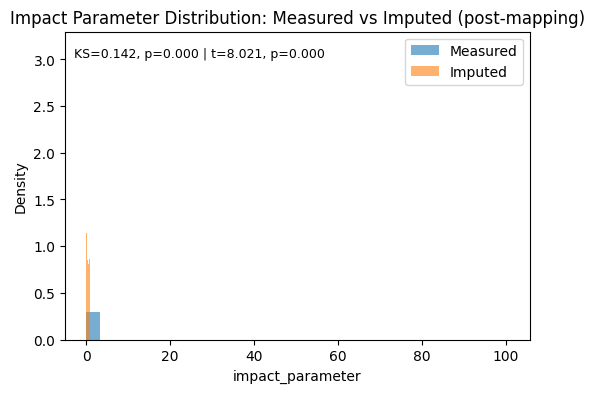

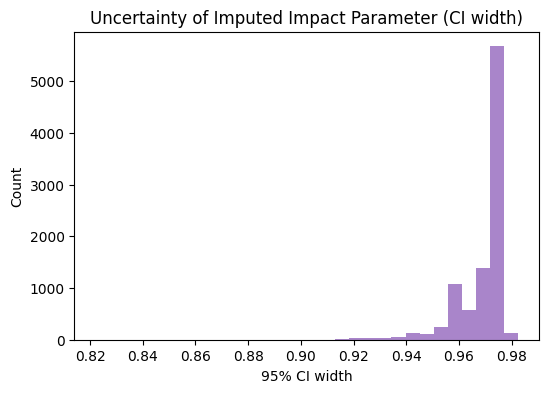

CI width: median=0.973, 90th pct=0.975
Saved diagnostics summary to data/exoplanet_null_analysis.csv


In [168]:
import pandas as pd
from scipy.stats import ks_2samp, ttest_ind
import matplotlib.pyplot as plt

measured = df.loc[~df['impact_parameter_imputed'], 'impact_parameter'].dropna()
imputed = df.loc[df['impact_parameter_imputed'], 'impact_parameter'].dropna()

print(f"Measured count: {len(measured)}, Imputed count: {len(imputed)}")

# KS test and t-test
if len(measured) > 10 and len(imputed) > 10:
    ks_stat, ks_p = ks_2samp(measured.values, imputed.values)
    t_stat, t_p = ttest_ind(measured.values, imputed.values, equal_var=False)
    stat_text = f"KS={ks_stat:.3f}, p={ks_p:.3f} | t={t_stat:.3f}, p={t_p:.3f}"
    print(f"KS test: stat={ks_stat:.3f}, p-value={ks_p:.3f}")
    print(f"t-test: t={t_stat:.3f}, p-value={t_p:.3f}")
else:
    ks_stat, ks_p = np.nan, np.nan
    t_stat, t_p = np.nan, np.nan
    stat_text = "Tests skipped (n<10)"
    print("Statistical tests skipped (insufficient samples)")

# Hist overlay with annotation
plt.figure(figsize=(6,4))
plt.hist(measured, bins=30, alpha=0.6, label='Measured', density=True)
plt.hist(imputed, bins=30, alpha=0.6, label='Imputed', density=True)
plt.xlabel('impact_parameter')
plt.ylabel('Density')
plt.legend()
plt.title('Impact Parameter Distribution: Measured vs Imputed (post-mapping)')
plt.text(0.02, 0.95, stat_text, transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')
plt.show()

# If uncertainty columns exist, visualize CI width (imputed rows only)
if {'impact_parameter_pred_std','impact_parameter_ci95_low','impact_parameter_ci95_high'}.issubset(df.columns):
    ci_width = (df.loc[df['impact_parameter_imputed'], 'impact_parameter_ci95_high'] -
                df.loc[df['impact_parameter_imputed'], 'impact_parameter_ci95_low']).dropna()
    if not ci_width.empty:
        plt.figure(figsize=(6,4))
        plt.hist(ci_width, bins=30, color='tab:purple', alpha=0.8)
        plt.xlabel('95% CI width')
        plt.ylabel('Count')
        plt.title('Uncertainty of Imputed Impact Parameter (CI width)')
        plt.show()
        print(f"CI width: median={ci_width.median():.3f}, 90th pct={ci_width.quantile(0.9):.3f}")

# Save summary CSV
summary = pd.DataFrame({
    'metric': ['count_measured','count_imputed','ks_stat','ks_pvalue','t_stat','t_pvalue'],
    'value': [len(measured), len(imputed), ks_stat, ks_p, t_stat, t_p]
})
summary_path = 'data/exoplanet_null_analysis.csv'
summary.to_csv(summary_path, index=False)
print(f"Saved diagnostics summary to {summary_path}")

##### SHAP-based Feature Importance for impact_parameter model
- Compute SHAP values for the median quantile GBM used in impact_parameter imputation.
- If SHAP is unavailable or fails, fall back to permutation importance.
- Expect duration_over_period to emerge as a strong contributor if informative.

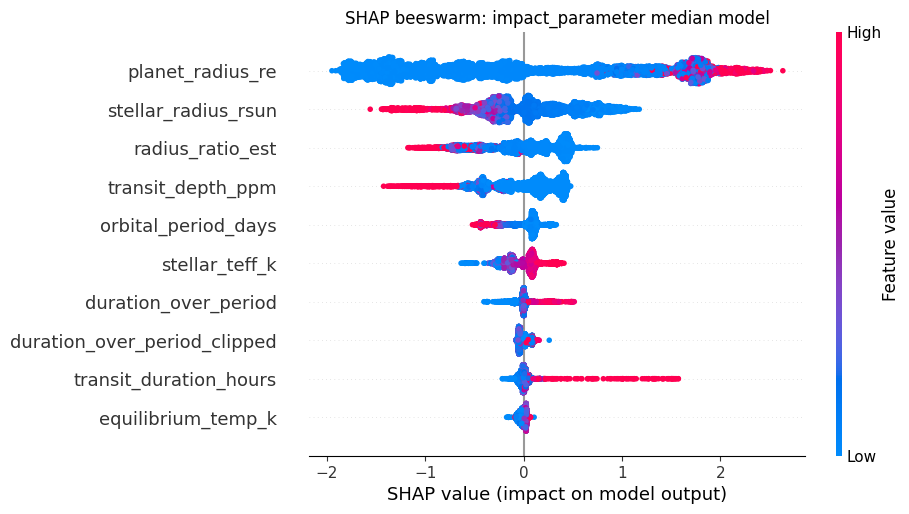

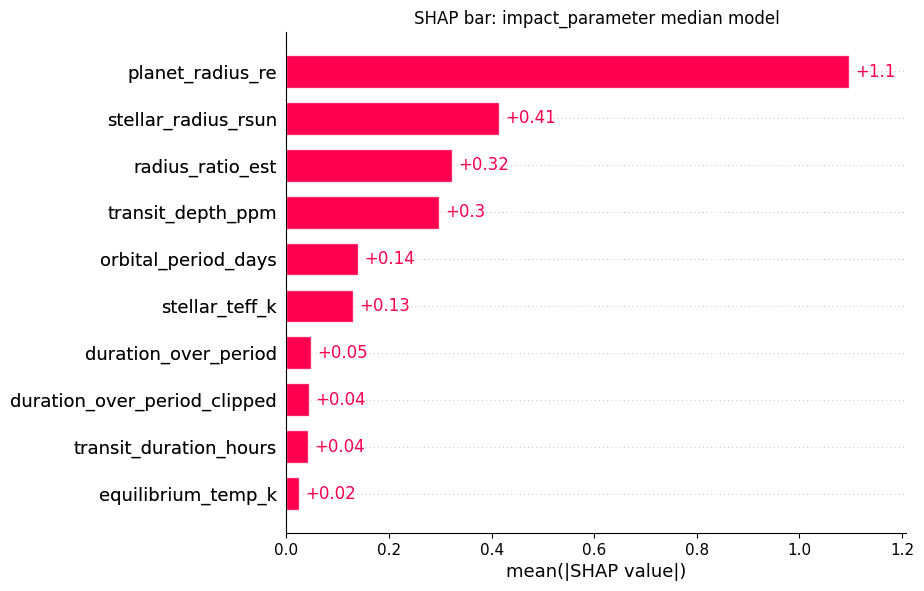

In [169]:
# SHAP feature importance for impact_parameter median model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Rebuild X_train and the median model on measured rows to ensure we have the fitted estimator here
measured_mask = (~df['impact_parameter_imputed']) & df['impact_parameter'].between(0,1)
impact_feats_present = [c for c in ['transit_depth_ppm','transit_duration_hours','orbital_period_days','equilibrium_temp_k',
                                     'duration_over_period','duration_over_period_clipped',
                                     'stellar_radius_rsun','stellar_teff_k','planet_radius_re','radius_ratio_est'] if c in df.columns]
train_df = df.loc[measured_mask, impact_feats_present + ['impact_parameter']].copy()
if len(train_df) >= 50 and len(impact_feats_present) > 0:
    X_train = train_df[impact_feats_present].fillna(train_df[impact_feats_present].median(numeric_only=True))
    eps = 1e-4
    y = train_df['impact_parameter'].clip(eps, 1-eps)
    y_logit = np.log(y/(1-y))
    # Fit the median quantile model
    from sklearn.ensemble import GradientBoostingRegressor
    gbm_med = GradientBoostingRegressor(loss='quantile', alpha=0.5, random_state=42)
    gbm_med.fit(X_train, y_logit)
    # Try SHAP
    shap_ok = False
    try:
        import shap
        explainer = shap.Explainer(gbm_med, X_train)
        shap_values = explainer(X_train)
        shap_ok = True
        shap.plots.beeswarm(shap_values, show=False)
        plt.title('SHAP beeswarm: impact_parameter median model')
        plt.show()
        shap.plots.bar(shap_values, show=False)
        plt.title('SHAP bar: impact_parameter median model')
        plt.show()
    except Exception as e:
        print(f"SHAP unavailable or failed: {type(e).__name__}: {e}")
    # Fallback: permutation importance on logit target
    if not shap_ok:
        pi = permutation_importance(gbm_med, X_train, y_logit, n_repeats=10, random_state=42, n_jobs=-1)
        imp = pd.Series(pi.importances_mean, index=impact_feats_present).sort_values(ascending=False)
        print('Permutation importance (logit target):')
        print(imp)
        plt.figure(figsize=(6,4))
        imp.iloc[:15][::-1].plot(kind='barh')
        plt.title('Permutation importance (top 15)')
        plt.tight_layout()
        plt.show()
else:
    print('SHAP importance skipped: insufficient measured data or features.')

## Note on generated MC frames for modeling
We produce a list `mc_frames` with 30–50 Monte Carlo samples of the final curated dataset using the saved uncertainty columns (e.g., `*_pred_std`, `ci95_low/high`). This is consumed by the training notebook to compute MC-robust performance with 95% CIs. If you need more draws, adjust `N_MC_DRAWS` below.

### Final Null Check

In [170]:
print(df.shape)

df.isna().mean() * 100

(18716, 39)


planet_name                        0.000000
host_star_id                       0.000000
mission                            0.000000
disposition                        0.000000
orbital_period_days                0.582389
transit_epoch_bjd                  0.000000
transit_duration_hours             2.094465
transit_depth_ppm                  0.000000
planet_radius_re                   0.000000
equilibrium_temp_k                 7.095533
insolation_flux                    7.512289
impact_parameter                   0.000000
stellar_teff_k                     0.000000
stellar_radius_rsun                0.000000
stellar_logg                       5.391109
ra                                 0.000000
dec                                0.000000
transit_epoch_bjd_imputed          0.000000
transit_duration_hours_imputed     0.000000
transit_depth_ppm_imputed          0.000000
radius_ratio_est                   0.000000
stellar_teff_k_pred_std           99.107715
stellar_teff_k_ci95_low         

### Remove Indiscriminate Row Dropping; Apply Targeted Final Imputation
- The previous dropna() discarded a large portion of data and has been removed.
- We now:
  - Inspect residual missingness.
  - Apply targeted, minimal imputation (median for numeric; mode for categorical) only for non-critical columns.
  - Optionally drop a row only if a critical subset required by the downstream task is missing and cannot be reliably imputed.
- This preserves data while keeping transparency through flagging.

In [171]:
# Targeted minimal final imputation (no indiscriminate row dropping)
# Define critical vs ancillary columns (adjust based on your downstream needs)
critical_cols = [c for c in ['transit_epoch_bjd','transit_duration_hours','transit_depth_ppm',
                             'orbital_period_days','impact_parameter'] if c in df.columns]

# 1) Simple median/mode impute for a small set of ancillary features
ancillary_candidates = [c for c in ['equilibrium_temp_k','stellar_logg','stellar_teff_k'] if c in df.columns]
for c in ancillary_candidates:
    before_miss = df[c].isna() if c in df.columns else None
    if df[c].dtype.kind in 'bifc':
        med = df[c].median(skipna=True)
        df[c] = df[c].fillna(med)
        if before_miss is not None:
            df[f'{c}_postfill_median'] = before_miss.values
    else:
        mode_val = df[c].mode(dropna=True)
        if not mode_val.empty:
            df[c] = df[c].fillna(mode_val.iloc[0])
            if before_miss is not None:
                df[f'{c}_postfill_mode'] = before_miss.values

# 2) Report rows still missing any critical col (do not drop here)
if critical_cols:
    still_critical_missing = df[critical_cols].isna().any(axis=1)
    print(f"Rows still missing at least one critical field: {still_critical_missing.sum()} of {len(df)}")

# Keep all rows; any downstream model can handle or specifically filter as needed
print('Final shape after targeted fills (no row drops):', df.shape)

Rows still missing at least one critical field: 501 of 18716
Final shape after targeted fills (no row drops): (18716, 42)


## Save final post-imputation dataset + compact diagnostics

This cell:
- Re-applies physical constraints safely (uses `apply_exoplanet_constraints` if available).
- Removes prior indiscriminate row dropping; retains all rows and transparently flags imputations and post-fills.
- Saves the final, fully imputed dataset to `data/unified_exoplanets_final_imputed.csv`.
- Prints a compact summary of all `*_imputed` flags and newly added `*_pred_std`/CI columns to verify uncertainty propagation.

In [172]:
# Avoid dropping rows post-imputation; inspect residual missingness and document uncertainty instead
residual = (df.isna().mean() * 100).sort_values(ascending=False)
print("Residual missingness by column (%):")
print(residual.round(2))

# Summarize uncertainty columns if present
unc_cols = [c for c in df.columns if c.endswith('_pred_std') or c.endswith('_ci95_low') or c.endswith('_ci95_high')]
if unc_cols:
    print("\nUncertainty columns present:")
    print(sorted(unc_cols))
else:
    print("\nNo uncertainty columns found yet (only flags present).")
# If you truly must drop, consider targeted drops on non-critical columns, not all rows.

Residual missingness by column (%):
stellar_teff_k_ci95_high              99.11
stellar_teff_k_ci95_low               99.11
stellar_teff_k_pred_std               99.11
stellar_radius_rsun_pred_std          97.30
stellar_radius_rsun_ci95_high         97.30
stellar_radius_rsun_ci95_low          97.30
planet_radius_re_ci95_low             97.22
planet_radius_re_pred_std             97.22
planet_radius_re_ci95_high            97.22
impact_parameter_pred_std             49.16
impact_parameter_ci95_high            49.16
impact_parameter_ci95_low             49.16
insolation_flux                        7.51
duration_over_period                   2.68
duration_over_period_clipped           2.68
transit_duration_hours                 2.09
orbital_period_days                    0.58
host_star_id                           0.00
equilibrium_temp_k                     0.00
planet_radius_re                       0.00
transit_depth_ppm                      0.00
transit_epoch_bjd                      0

### Optional: Monte Carlo-ready uncertainty usage
- Use the saved `*_pred_std` and CI columns to sample plausible values for downstream models.
- This example shows how to generate a few Monte Carlo draws for `impact_parameter` and radii and aggregate them.

### Evaluate a downstream classifier across MC datasets
- This wrapper takes the MC-sampled DataFrames and trains/evaluates a classifier on each draw.
- Aggregates metrics across draws (mean ± std).
- Example below uses a simple scikit-learn pipeline; replace with your model/task as needed.

In [173]:
# Utility: generate Monte Carlo-sampled DataFrames for downstream modeling
def generate_mc_datasets(df_in: pd.DataFrame, n_draws: int = 10, seed: int = 42,
                          columns_with_unc: list | None = None,
                          bounds: dict | None = None) -> list[pd.DataFrame]:
    """
    Returns a list of DataFrames where imputed columns with available *_pred_std are sampled.
    - columns_with_unc: if None, autodetect columns ending with _pred_std to decide which bases to sample.
    - bounds: optional dict of {col: (low, high)} to clip sampled values (e.g., impact_parameter: (0,1)).
    """
    rng = np.random.default_rng(seed)
    df_base = df_in.copy()
    # autodetect uncertainty-enabled columns
    if columns_with_unc is None:
        columns_with_unc = sorted({c[:-9] for c in df_base.columns if c.endswith('_pred_std')})
    draws = []
    for k in range(n_draws):
        df_draw = df_base.copy()
        for col in columns_with_unc:
            std_col = f"{col}_pred_std"
            if col in df_draw.columns and std_col in df_draw.columns:
                mu = df_draw[col]
                sd = df_draw[std_col].fillna(0.0)
                sample = rng.normal(mu, sd)
                # clip to bounds if provided
                if bounds and col in bounds:
                    lo, hi = bounds[col]
                    sample = np.clip(sample, lo, hi)
                df_draw[col] = sample
        draws.append(df_draw)
    return draws

# Example usage: create 20 MC datasets and (optionally) save them
bounds = {'impact_parameter': (0.0, 1.0)}
mc_datasets = generate_mc_datasets(df, n_draws=20, bounds=bounds)
print(f"Generated {len(mc_datasets)} MC datasets with uncertainty sampling.")

Generated 20 MC datasets with uncertainty sampling.


In [174]:
# MC evaluation wrapper example
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

def evaluate_classifier_over_mc(mc_frames: list[pd.DataFrame], feature_cols: list[str], target_col: str,
                                 test_size: float = 0.2, random_state: int = 42) -> dict:
    metrics = {'accuracy': [], 'roc_auc': []}
    for i, frame in enumerate(mc_frames):
        df_mc = frame.dropna(subset=feature_cols + [target_col])  # minimal safeguard; adjust if needed
        if len(df_mc) < 100:
            continue
        X = df_mc[feature_cols]
        y = df_mc[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state + i, stratify=y if y.nunique()==2 else None)
        # Simple baseline; replace with your model
        clf = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=200))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        metrics['accuracy'].append(acc)
        # Optional AUC if binary labels and predict_proba available
        if y.nunique() == 2 and hasattr(clf, 'predict_proba'):
            proba = clf.predict_proba(X_test)[:,1]
            try:
                auc = roc_auc_score(y_test, proba)
            except Exception:
                auc = float('nan')
            metrics['roc_auc'].append(auc)
    # Aggregate
    out = {}
    for k, vals in metrics.items():
        if len(vals) > 0:
            out[k] = {'mean': float(np.nanmean(vals)), 'std': float(np.nanstd(vals)), 'n': len(vals)}
    return out

# Example usage (adjust feature_cols and target_col for your specific task)
# feature_cols = ['impact_parameter','transit_depth_ppm','transit_duration_hours','orbital_period_days']
# target_col = 'your_label_column'
# results = evaluate_classifier_over_mc(mc_datasets, feature_cols, target_col)
# print('MC evaluation results:', results)

In [175]:
import os

# 0) Re-apply physical constraints before saving (safe, optional)
try:
    if 'apply_exoplanet_constraints' in globals():
        if 'orbital_period_days' in df.columns:
            df = apply_exoplanet_constraints(df, period_col='orbital_period_days')
        else:
            print("Constraint enforcement skipped: 'orbital_period_days' not found.")
    # Minimal fallback to ensure strictly positive durations
    if 'transit_duration_hours' in df.columns:
        df['transit_duration_hours'] = df['transit_duration_hours'].clip(lower=0.001)
except Exception as e:
    print(f"Constraint enforcement error [{type(e).__name__}]: {e}")

# 1) Determine save path
out_dir = os.path.join('data')
os.makedirs(out_dir, exist_ok=True)
final_csv = os.path.join(out_dir, 'unified_exoplanets_final_imputed.csv')

# 2) Optionally drop helper columns not needed downstream (keep uncertainty and flags)
aux_cols = []
for c in ['radius_ratio_est']:
    if c in df.columns:
        aux_cols.append(c)

# Keep all *_imputed and *_pred_std / ci cols
cols_to_keep = [c for c in df.columns if True]
df_to_save = df[cols_to_keep].drop(columns=aux_cols, errors='ignore').copy()

# 3) Compute compact diagnostics based on available *_imputed flags and uncertainty columns
flag_cols = [c for c in df_to_save.columns if c.endswith('_imputed')]
unc_cols = [c for c in df_to_save.columns if c.endswith('_pred_std') or c.endswith('_ci95_low') or c.endswith('_ci95_high')]
compact_diag = {}
for c in sorted(flag_cols):
    try:
        compact_diag[c] = int(df_to_save[c].sum())
    except Exception:
        compact_diag[c] = None

# 4) Persist
try:
    df_to_save.to_csv(final_csv, index=False)
    print(f"Saved final imputed dataset to: {final_csv}")
except Exception as e:
    print(f"Failed to save final dataset: {e}")

# 5) Show quick QA summary
if compact_diag:
    summary_df = pd.DataFrame([
        {'flag': k, 'count_imputed': v if v is not None else 'n/a'} for k, v in compact_diag.items()
    ])
    print("\nImputation flags summary (counts):")
    print(summary_df.to_string(index=False))
else:
    print("No *_imputed flag columns found; nothing to summarize.")

if unc_cols:
    print("\nUncertainty columns saved:")
    print(sorted(unc_cols))
else:
    print("\nNo uncertainty columns to save.")

Saved final imputed dataset to: data\unified_exoplanets_final_imputed.csv

Imputation flags summary (counts):
                          flag  count_imputed
      impact_parameter_imputed           9515
      planet_radius_re_imputed            521
   stellar_radius_rsun_imputed            506
        stellar_teff_k_imputed            167
     transit_depth_ppm_imputed           1895
transit_duration_hours_imputed           2132
     transit_epoch_bjd_imputed           1847

Uncertainty columns saved:
['impact_parameter_ci95_high', 'impact_parameter_ci95_low', 'impact_parameter_pred_std', 'planet_radius_re_ci95_high', 'planet_radius_re_ci95_low', 'planet_radius_re_pred_std', 'stellar_radius_rsun_ci95_high', 'stellar_radius_rsun_ci95_low', 'stellar_radius_rsun_pred_std', 'stellar_teff_k_ci95_high', 'stellar_teff_k_ci95_low', 'stellar_teff_k_pred_std']


In [176]:
# Example Monte Carlo sampling for downstream modeling (optional)
def sample_with_uncertainty(mean_vals, std_vals, lower=None, upper=None, n_draws=10, seed=42):
    rng = np.random.default_rng(seed)
    draws = []
    for _ in range(n_draws):
        # approximate normal; clip to provided bounds if any
        s = std_vals.fillna(0.0)
        m = mean_vals
        draw = rng.normal(loc=m, scale=s)
        if lower is not None:
            draw = np.maximum(draw, lower)
        if upper is not None:
            draw = np.minimum(draw, upper)
        draws.append(draw)
    return np.stack(draws, axis=1)  # shape (n, n_draws)

mc = {}
if {'impact_parameter','impact_parameter_pred_std'}.issubset(df.columns):
    lower = df.get('impact_parameter_ci95_low', pd.Series(index=df.index, data=0.0))
    upper = df.get('impact_parameter_ci95_high', pd.Series(index=df.index, data=1.0))
    mc['impact_parameter'] = sample_with_uncertainty(df['impact_parameter'], df['impact_parameter_pred_std'],
                                                     lower=lower, upper=upper, n_draws=10)
    print('Generated MC draws for impact_parameter:', mc['impact_parameter'].shape)

for tgt in ['stellar_radius_rsun','planet_radius_re','stellar_teff_k']:
    std_col = f'{tgt}_pred_std'
    if tgt in df.columns and std_col in df.columns:
        mc[tgt] = sample_with_uncertainty(df[tgt], df[std_col], n_draws=10)
        print(f'Generated MC draws for {tgt}:', mc[tgt].shape)

Generated MC draws for impact_parameter: (18716, 10)
Generated MC draws for stellar_radius_rsun: (18716, 10)
Generated MC draws for planet_radius_re: (18716, 10)
Generated MC draws for stellar_teff_k: (18716, 10)
